# Gene Expression Assay: 
# A New Panel for Early Metastatic Risk Estimation for Breast Cancer

Number of Samples 202
" First 101 observation of DATA is MET and other 101 is NON_MET"
Gen sayısı : 54675 

number of observation is less then the number of features 
we need feature selection

We take data for each gene and separated them by classes. 
draw histograms of the values of two separate classes.
We used the normalized version of the difference of the histograms to decide whether to use that gene.
We know that if the Distributions are very close to each other, there would be no useful information.

In [1]:
import pandas as pd
import numpy as np
import glob
import pickle
import random
import matplotlib.pyplot as plt
%matplotlib inline

### raw_data adlı bir alt dizin açtım ve içine bana yolladığınız csv dosyaları attım

In [2]:
fnames = glob.glob('raw_data/*.csv')
fnames

['raw_data\\geneData10000.csv',
 'raw_data\\geneData15000.csv',
 'raw_data\\geneData20000.csv',
 'raw_data\\geneData25000.csv',
 'raw_data\\geneData30000.csv',
 'raw_data\\geneData35000.csv',
 'raw_data\\geneData40000.csv',
 'raw_data\\geneData45000.csv',
 'raw_data\\geneData5000.csv',
 'raw_data\\geneData50000.csv',
 'raw_data\\geneData54675.csv']

In [3]:
for fname in fnames:
    df = pd.read_csv(fname)    
    cols = list(df.columns[1:])    
    mat = df.values[:,1:]
    print(fname ,' : ', mat.min(),mat.mean(),mat.max())

raw_data\geneData10000.csv  :  1.973257949 4.157567203352784 14.39419445
raw_data\geneData15000.csv  :  1.973257949 8.082153651300729 14.39419445
raw_data\geneData20000.csv  :  1.973257949 6.263881789169205 14.39419445
raw_data\geneData25000.csv  :  1.973257949 6.7903501634908485 14.39419445
raw_data\geneData30000.csv  :  1.973257949 6.2653758114362335 14.20849554
raw_data\geneData35000.csv  :  1.973257949 6.883478812859307 14.39419445
raw_data\geneData40000.csv  :  2.01185632089109 6.587700044001167 14.20849554
raw_data\geneData45000.csv  :  1.973257949 5.115765048563669 13.82001836
raw_data\geneData5000.csv  :  1.973257949 4.774077435310826 14.39419445
raw_data\geneData50000.csv  :  1.973257949 4.894179649272543 13.80823055
raw_data\geneData54675.csv  :  1.973257949 5.0552971525902395 14.39419445


### Dosya çok büyük olduğundan ayrı ayrı okunup her dosyadaki değerlerin maksimum minimum ve ortalama değerleri hesaplanıyor
Bütün değerler 15 den küçük histogram aralığı (0 ,15 )  seçiliyor

In [4]:
hist_range = (0,15)

In [5]:
histogram_difference_thresh = 0.41584158
hist_range = (0,15)
histogram_difference = []
fname_list = []
gene_list = []
data_list = []
hist_list = []
for fname in fnames:
    df = pd.read_csv(fname)    
    cols = list(df.columns[1:])    
    mat = df.values[:,1:]
    mat_lower = mat[:101,:]
    mat_upper = mat[101:,:]
    for i in range(mat.shape[1]):
        vec_met =  mat_lower[:,i]
        vec_non_met =  mat_upper[:,i]
        hist_met, _  = np.histogram(vec_met,bins=100,range=hist_range)
        hist_non_met, _  = np.histogram(vec_non_met,bins=100,range=hist_range)
        dfact = np.abs(hist_met - hist_non_met).sum() / 202
        gene_list.append(cols[i])
        fname_list.append(fname)
        histogram_difference.append(dfact)
        data_list.append(mat[:,i])
        hist_list.append([hist_met,hist_non_met])

### Histogram farklarının histogramına bakıyoruz 

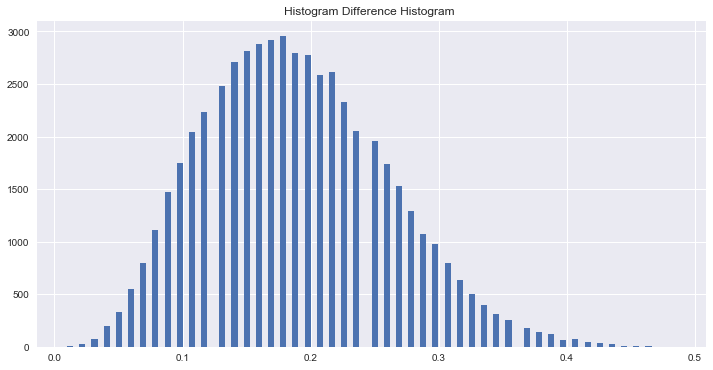

In [6]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Histogram Difference Histogram ')
#ax.set_ylim(0,10)
#ax.set_xlim(0,100)
_ = ax.hist(histogram_difference,bins=100)

### En büyük Histogram farkına sahip geni ve dağılımlarına bakıyoruz

In [7]:
ix = np.argmax(histogram_difference)
histogram_difference[ix]

0.48514851485148514

In [8]:
h_met,h_non_met = hist_list[ix]

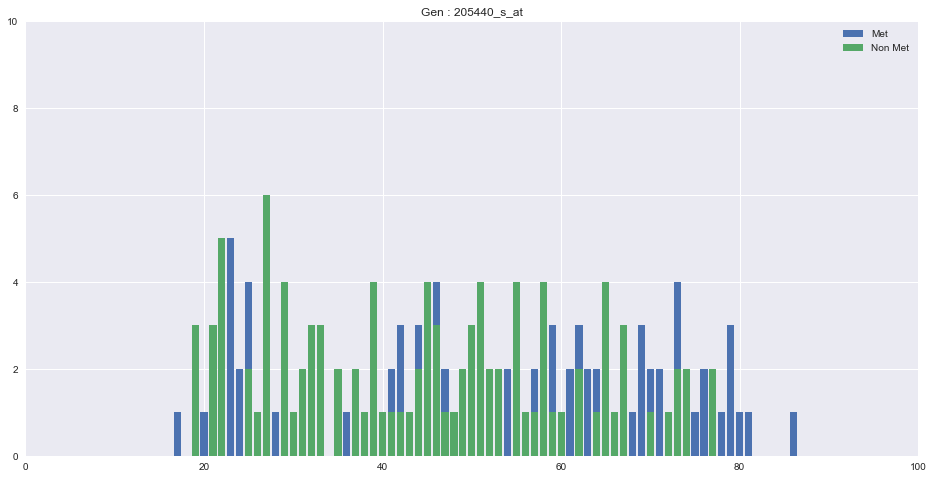

In [9]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Gen : '+gene_list[ix])
ax.set_ylim(0,10)
ax.set_xlim(0,100)
ax.bar(range(100), h_met, label='Met')
ax.bar(range(100), h_non_met,label='Non Met')
ax.legend()

### Farkın büyük olduğu tarafta ortalama + 3 x standart sapma üstündeki genlerden seçiyoruz

In [10]:
histogram_difference =  np.array(histogram_difference)

In [11]:
histogram_difference.min(),histogram_difference.mean(),histogram_difference.max(),histogram_difference.std()

(0.009900990099009901,
 0.18839913620991733,
 0.48514851485148514,
 0.0711749440573266)

In [12]:
histogram_difference_thresh = histogram_difference.mean() + 3* histogram_difference.std()
histogram_difference_thresh

0.40192396838189715

In [13]:
len(histogram_difference[histogram_difference > histogram_difference_thresh])

208

### 208 tane öznitelik 202 tane örneği olan bir problem için yine fazla  
### eşik değeri biraz daha artırıp  öznitelik sayısını biraz daha düşürüyoruz

In [14]:
histogram_difference_thresh = 0.41584158
len(histogram_difference[histogram_difference > histogram_difference_thresh])

133

In [15]:
selected_gens = histogram_difference > histogram_difference_thresh

In [16]:
data_X  = np.array(data_list)[selected_gens].transpose()
n = 101
y = np.array(n*[1] + n*[0])

In [17]:
data_X.shape,y.shape

((202, 133), (202,))

### Seçtiğimiz verileri Kaydediyoruz

In [18]:
np.save('data/data_x.npy',data_X)
np.save('data/data_y.npy',y)

In [19]:
with open('data/feature_names.pkl','wb') as fp:
    pickle.dump(list(np.array(gene_list)[selected_gens]),fp)

In [20]:
with open('data/file_names.pkl','wb') as fp:
    pickle.dump(list(np.array(fname_list)[selected_gens]),fp)

In [21]:
with open('data/feature_histograms.pkl','wb') as fp:
    pickle.dump(list(np.array(hist_list)[selected_gens]),fp)